# Retrieve the companies that are part of S&P 500
March 10th 2022  
S&P companies= from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies  
Sectors= from https://en.wikipedia.org/wiki/Global_Industry_Classification_Standard

In [2]:
import sys, os
print(sys.executable)
print(os.getcwd())
from datetime import datetime
import re
import shutil # high-level file operation
import wikipedia as wp
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

/home/razielar/miniconda3/envs/time-series/bin/python
/home/razielar/Documents/git_rep/Machine_learning/time_series_forecasting/SP-500-time-series-forecasting/data_retrieve


In [3]:
# Configurations
import src.plotSetttigs

## 1) Start

In [4]:
def get_table(title, match, use_cache=False):
    """
    Function to download the lis of the 500 companies inside S&P500
    Arguments:
    title: (str) => title of the Wikipedia page
    filename: (str) => name of the output filename
    match: (str) => first colum name
    """
    if use_cache and os.path.isfile(filename):
        pass
    else:
        html = wp.page(title).html()
        df = pd.read_html(html, header=0, match=match)[0]
    return df

In [5]:
%%time
title = 'List of S&P 500 companies'
match= 'Symbol'

sp500 = get_table(title, match='Symbol')

CPU times: user 517 ms, sys: 22.2 ms, total: 540 ms
Wall time: 5.27 s


* SEC: US Securities and Exchange Commission
* GICS: Global Industry Classification Standard
* CIK: Central Index Key; number given to a company by the SEC

In [6]:
sp500.columns= sp500.columns.str.lower()
sp500.drop(columns= 'sec filings', inplace= True)
sp500.rename(columns= {"symbol":"ticker", "security":"company", "gics sector": "gics_sector", 
                       "gics sub-industry": "gics_sub_industry", "headquarters location": "headquarters_location",
                       "date first added": "date_first_added"}, inplace= True)
# sp500.to_csv(data_path+filename, header=True, index=False, encoding='utf-8')

In [7]:
sp500.head()

,ticker,company,gics_sector,gics_sub_industry,headquarters_location,date_first_added,cik,founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


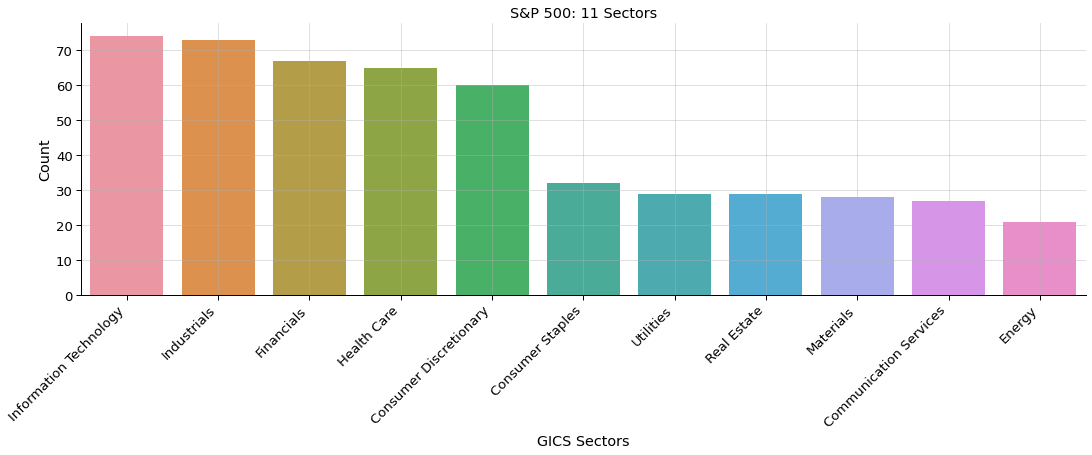

In [38]:
image_dir= "../plots/eda/"
plot_name= "sp500.sectors.pdf"

sns.set_context("paper", font_scale= 1.5)
sns.countplot(x= "gics_sector", data= sp500, 
              order= sp500['gics_sector'].value_counts().index)
plt.ylabel("Count")
plt.xlabel("GICS Sectors")
plt.title("S&P 500: {} Sectors".format(len(Counter(sp500['gics_sector']))))
plt.xticks(rotation=45, horizontalalignment='right')
plt.grid(alpha= 0.5)

plt.savefig(image_dir+plot_name)

plt.show()

## Get Sector df for deeper analysis

In [10]:
%%time
sector_title= 'Global Industry Classification Standard'
sector_match= 'Sector'
sector_df= get_table(title= sector_title, match= sector_match)

CPU times: user 98.2 ms, sys: 3.25 ms, total: 101 ms
Wall time: 1.57 s


In [11]:
sector_df.columns= sector_df.columns.str.lower()
sector_df.drop(columns= ['sector', 'industry group', 'industry', 'sub-industry'], inplace= True)
sector_df.columns= sector_df.columns.str.replace(".1", "", regex= True)
sector_df.rename(columns= {"sector": "gics_sector", "industry group": "industry_group", 
                           "sub-industry": "gics_sub_industry"}, inplace= True)

In [35]:
pd.set_option('display.max_rows', 600)
# sector_df
# sector_df.sort_values(by= ['sector'])
# df.sort_values(by=['col1'])

## Merge DFs

In [12]:
# pd.merge(sp500, sector_df)
display(sp500.head())
sector_df.head()

,ticker,company,gics_sector,gics_sub_industry,headquarters_location,date_first_added,cik,founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


,gics_sector,industry_group,industry,gics_sub_industry
0,Energy,Energy,Energy Equipment & Services,Oil & Gas Drilling
1,Energy,Energy,Energy Equipment & Services,Oil & Gas Equipment & Services
2,Energy,Energy,"Oil, Gas & Consumable Fuels",Integrated Oil & Gas
3,Energy,Energy,"Oil, Gas & Consumable Fuels",Oil & Gas Exploration & Production
4,Energy,Energy,"Oil, Gas & Consumable Fuels",Oil & Gas Refining & Marketing


In [13]:
merged_df= pd.merge(left= sp500, right= sector_df)
merged_df= merged_df[['ticker', 'cik', 'company', 'gics_sector', 'industry_group', 'industry', 'gics_sub_industry',
                      'headquarters_location', 'founded' ,'date_first_added']]

In [15]:
data_path= '../data/'
filename = 'sp500.companies.csv'
merged_df.to_csv(data_path+filename, header=True, index=False, encoding='utf-8')

In [16]:
merged_df.head()

,ticker,cik,company,gics_sector,industry_group,industry,gics_sub_industry,headquarters_location,founded,date_first_added
0,MMM,66740,3M,Industrials,Capital Goods,Industrial Conglomerates,Industrial Conglomerates,"Saint Paul, Minnesota",1902,1976-08-09
1,GE,40545,GE,Industrials,Capital Goods,Industrial Conglomerates,Industrial Conglomerates,"Boston, Massachusetts",1892,NaN
2,HON,773840,Honeywell,Industrials,Capital Goods,Industrial Conglomerates,Industrial Conglomerates,"Charlotte, North Carolina",1906,1964-03-31
3,ROP,882835,Roper,Industrials,Capital Goods,Industrial Conglomerates,Industrial Conglomerates,"Sarasota, Florida",1981,2009-12-23
4,AOS,91142,A. O. Smith,Industrials,Capital Goods,Building Products,Building Products,"Milwaukee, Wisconsin",1916,2017-07-26


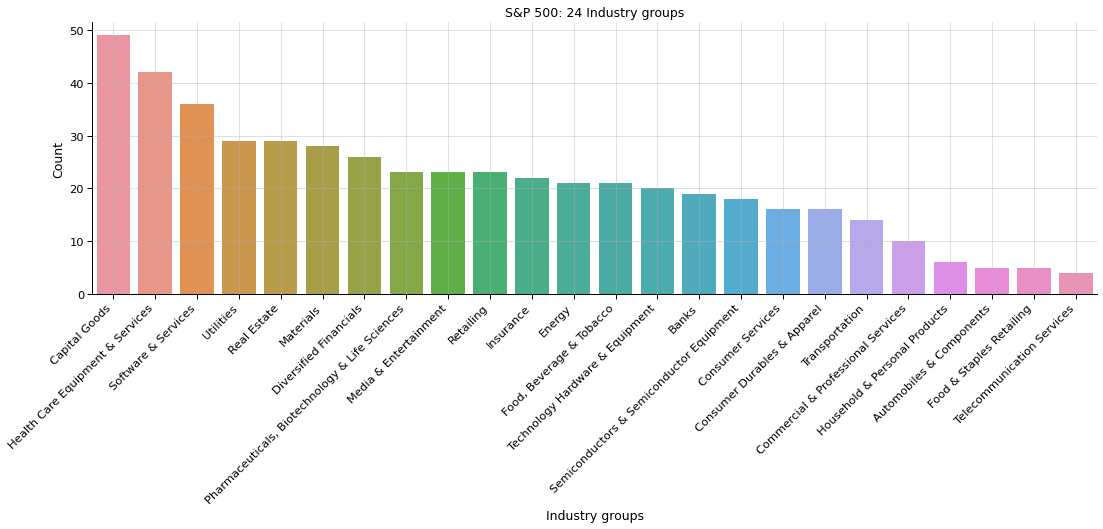

In [43]:
# Counter(merged_df['industry_group'])

plot_name= "sp500.industry.groups.pdf"

sns.set_context("paper", font_scale= 1.3)
sns.countplot(x= "industry_group" , data= merged_df,
             order= merged_df['industry_group'].value_counts().index)
plt.xticks(rotation=45, horizontalalignment='right')
plt.title("S&P 500: {} Industry groups".format(len(Counter(merged_df['industry_group']))))
plt.ylabel("Count")
plt.xlabel("Industry groups")
plt.grid(alpha= 0.5)

plt.savefig(image_dir+plot_name)

plt.show()

In [19]:
# Counter(merged_df['industry'])

In [21]:
# Counter(merged_df['gics_sub_industry'])